# Pattern Recognition - IUST - Fall 98
## Taha Samavati - 98722134
### Second Project - Ensembles

In [5]:
# imports
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import math
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from math import log
import random
import os
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

* Read dataset

In [26]:
# read data set - vehicle0.dat consisting of 846 data points each with 18 features and a binary label
features = np.zeros((846,18))
labels = np.zeros((846,),dtype=np.uint8)

with open('./vehicle0.dat','r') as file:
    a = file.readlines()
    for i in range(len(a)):
        a[i] = a[i].replace(" ","")
        b = a[i].split(',')
        if b[18] == 'positive\n':
            b[18] = 1
        elif b[18] == 'negative\n':
            b[18] = 0
        features[i,:] = np.array(b[:18])
        labels[i] = b[18]

# 1.AdaBoost M2

In [8]:
class AdaboostM2():
    
    def __init__(self, instances, labels, n_clf):
        self.X = instances
        self.y = labels.tolist()
        
        self.clf = []
        self.n_clf = n_clf
            
        self.weights = []
        self.init_weight= 1.0 / len(self.X)
        
        for i in range(len(self.X)):# Assign initial weights to datapoints
            self.weights.append(self.init_weight)

        self.beta = []
        
    def fit(self):
        
        for k in range(self.n_clf):
            
            base_classifier = DT(max_depth=2)# construct base classifier
            base_classifier.fit(self.X, self.y, self.weights)

            self.clf.append(base_classifier)
            
            loss = 0
            for x,y,w in zip(self.X, self.y, self.weights):
                x = x.reshape(1,-1)
                probs = self.clf[k].predict_proba(x)[0]
                pred = self.clf[k].predict(x)[0]
                if y != pred:
                    loss+= w * (1 - probs[y] + probs[pred])
            loss *= 0.5
            beta = loss/(1-loss)
            if math.isnan(beta) or beta == 0:
                beta = 1
            self.beta.append(beta)
            
            if loss > 0: # update weights if there is a loss
                for i in range(len(self.weights)):
                    x = self.X[i]
                    x = x.reshape(1,-1)
                    probs = self.clf[k].predict_proba(x)[0]
                    pred = self.clf[k].predict(x)[0]
                    #if self.y[i] != pred:
                    self.weights[i] = self.weights[i] * (np.power(beta,(0.5*(1 + probs[y] - probs[pred]))))
            
            # use total sum to normalize sum of weights to 1.0
            sum_weight = sum(self.weights)
            self.weights = [w / sum_weight for w in self.weights]
            
    def predict(self, instance):# compute positive class and negative class score
        
        p_score, n_score = 0 , 0
        instance = instance.reshape(1,-1)
        
        for i in range(self.n_clf):
            pred = self.clf[i].predict(instance)[0]
            probs = self.clf[i].predict_proba(instance)[0]
            if pred == 1:
                p_score += np.log(1/self.beta[i])* probs[1]
            else:
                n_score += np.log(1/self.beta[i])* probs[0]

        if n_score <= p_score:
            return 1
        else:
            return 0

Precision and recall for ensemble size of : 10
ADABOOST: Avg Precision= 0.76 Avg Recall= 0.9
Precision and recall for ensemble size of : 50
ADABOOST: Avg Precision= 0.77 Avg Recall= 0.9
Precision and recall for ensemble size of : 100
ADABOOST: Avg Precision= 0.77 Avg Recall= 0.9


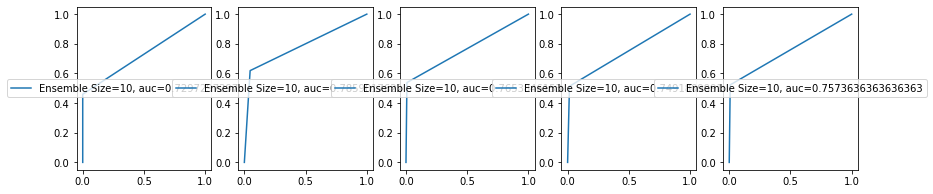

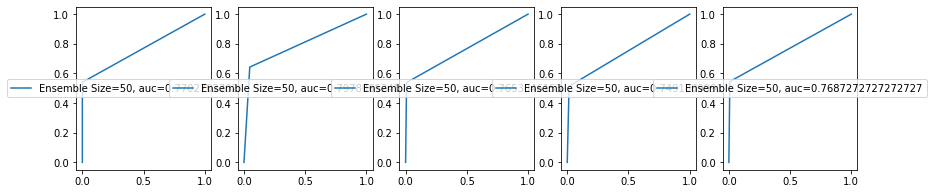

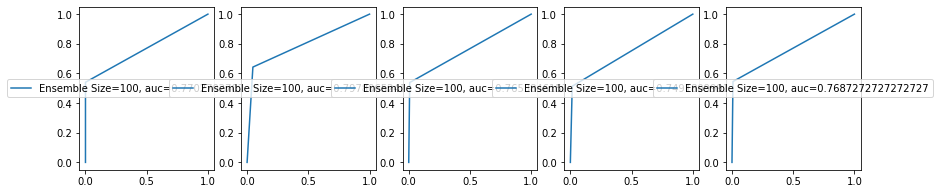

In [9]:
kf = KFold(n_splits=5,random_state=76,shuffle=True) # 5fold cross validation

def train_adaboost(xtrain, ytrain, xtest, ytest, indx, ensemble_size=10, plot_roc=False):

    ada = AdaboostM2(features,labels,ensemble_size)
    ada.fit()
    
    preds=[]
    for i in range(xtest.shape[0]):
        preds.append(ada.predict(xtest[i]))
    if plot_roc:
        # plot roc curve
        fpr, tpr, _ = roc_curve(ytest, preds)
        roc_auc = auc(fpr, tpr)

        ax[indx].plot(fpr,tpr,label="Ensemble Size="+str(esize)+", auc="+str(roc_auc))
        ax[indx].legend(loc=10)
        if indx==5:
            plt.show()
    
    prec,recall,_,_ = precision_recall_fscore_support(preds, ytest)
    return prec,recall

# For each ensemble size train clf with adaboost algorithm
ensemble_size=[10,50,100]
avg_prec_ada, avg_rcall_ada = [], []

for esize in ensemble_size:
    p_ada,r_ada=[],[] # lists for storing precisions and recalls
    indx=0
    fig, ax = plt.subplots(1,5,figsize=(14,3))
    
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # ADABOOST
        precision,recall = train_adaboost(X_train, y_train,X_test,y_test, indx, esize)
        p_ada.append(precision)
        r_ada.append(recall)
        indx+=1

    print("Precision and recall for ensemble size of : "+str(esize))
    avg_prec_ada.append(np.mean(p_ada))
    avg_rcall_ada.append(np.mean(r_ada))
    print("ADABOOST: Avg Precision= "+str(round(avg_prec_ada[-1],2))+" Avg Recall= "+str(round(avg_rcall_ada[-1],2)))
    print("=========================================================")

# 2. RUSBoost

In [10]:
class RUSBoost:
    
    def __init__(self, instances, labels, n_clf, desired_balance):
        
        self.X = instances
        self.y = labels.tolist()
        
        self.clf = []
        self.n_clf = n_clf
            
        self.weights = []
        self.init_weight= 1.0 / len(self.X)
        for i in range(len(self.X)):
            self.weights.append(self.init_weight)
            
        self.ratio = desired_balance
        self.beta = []

    
    def undersampling(self):

        # Check the major class

        diff = self.y.count(1) > self.y.count(0)
        delete_list = []
        keep_list =[]
        
        if  diff: # if positive class is the major class 
            for i in range(len(self.y)):
                # store positive samples in delete data
                if self.y[i] == 1:
                    delete_data = [i, self.X[i], 1]
                    delete_list.append(delete_data)
                else:
                    keep_data = [i, self.X[i], 0]
                    keep_list.append(keep_data)
        else:# if negative class is the major class 
            for i in range(len(self.y)):
                # store positive samples in delete data
                if self.y[i] == 0:
                    delete_data = [i, self.X[i], 0]
                    delete_list.append(delete_data)
                else:
                    keep_data = [i, self.X[i], 1]
                    keep_list.append(keep_data)
        
        # randomly delete major class samples until the desired balance is reached
        while len(delete_list) > self.ratio*(len(delete_list)+len(keep_list)):
            k = random.choice(range(len(delete_list)))
            delete_list.pop(k)
        
        all_list = delete_list + keep_list
        return sorted(all_list, key=lambda x:x[2])
    
    def predict(self, instance):
        
        p_score, n_score = 0 , 0
        instance = instance.reshape(1,-1)
        
        for i in range(self.n_clf):
            pred = self.clf[i].predict(instance)[0]
            probs = self.clf[i].predict_proba(instance)[0]
            if pred == 1:
                p_score += np.log(1/self.beta[i]) * probs[1]
            else:
                n_score += np.log(1/self.beta[i]) * probs[0]
        if n_score <= p_score:
            return 1
        else:
            return 0
        
    def fit(self):
        for k in range(self.n_clf):

            sampled = self.undersampling()

            sampled_weight = [self.weights[s[0]] for s in sampled]
            sampled_X      = [s[1] for s in sampled]
            sampled_Y       = [s[2] for s in sampled]
            
            base_classifier = DT(max_depth=2)
            base_classifier.fit(sampled_X, sampled_Y, sampled_weight)
            
            self.clf.append(base_classifier)

            loss = 0
            for x,y,w in zip(self.X, self.y, self.weights):
                x = x.reshape(1,-1)
                probs = self.clf[k].predict_proba(x)[0]
                pred = self.clf[k].predict(x)[0]
                if y != pred:
                    loss+= w * (1 - probs[y] + probs[pred])
            loss *= 0.5
            beta = loss/(1-loss)
            if math.isnan(beta) or beta == 0:
                beta = 1
            self.beta.append(beta)
            if loss > 0: # update weights if there is a loss
                
                for i in range(len(self.weights)):
                    x = self.X[i]
                    x = x.reshape(1,-1)
                    probs = self.clf[k].predict_proba(x)[0]
                    pred = self.clf[k].predict(x)[0]
                    #if self.y[i] != pred:
                    self.weights[i] = self.weights[i] * (np.power(beta,(0.5*(1 + probs[y] - probs[pred]))))
            
            # use total sum to normalize sum of weights to 1.0
            sum_weight = sum(self.weights)
            self.weights = [w / sum_weight for w in self.weights]

Precision and recall for ensemble size of : 10
RUSBOOST: Avg Precision= 0.82 Avg Recall= 0.75
Precision and recall for ensemble size of : 50
RUSBOOST: Avg Precision= 0.81 Avg Recall= 0.76
Precision and recall for ensemble size of : 100
RUSBOOST: Avg Precision= 0.81 Avg Recall= 0.75


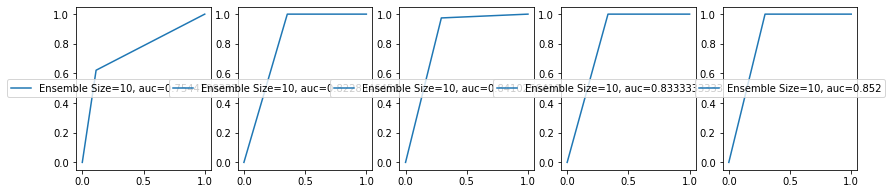

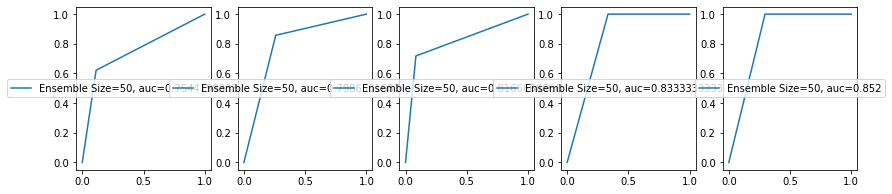

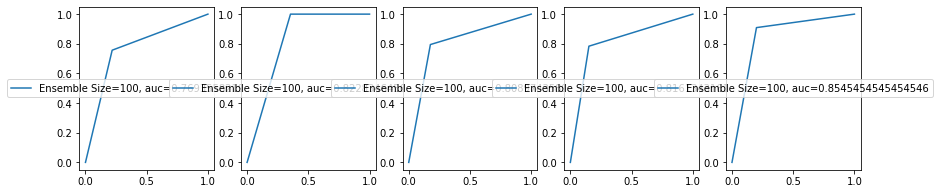

In [11]:
def train_rusboost(xtrain, ytrain, xtest, ytest, indx, ensemble_size=10, plot_roc=False):
    
    rate = 0.5
    rus = RUSBoost(xtrain, ytrain, ensemble_size, rate)
    rus.fit()
    
    preds=[]
    for i in range(xtest.shape[0]):
        preds.append(rus.predict(xtest[i]))
    if plot_roc:
        # plot ROC curves
        fpr, tpr, _ = roc_curve(ytest, preds)
        roc_auc = auc(fpr, tpr)

        ax[indx].plot(fpr,tpr,label="E.S="+str(esize)+", auc="+str(roc_auc))
        ax[indx].legend(loc=10)
        if indx==5:
            plt.show()
    
    prec,recall,_,_ = precision_recall_fscore_support(preds, ytest)
    return prec,recall

# define ensemble sizes
ensemble_size=[10,50,100]
avg_prec_rb, avg_rcall_rb=[],[]

for esize in ensemble_size:
    # lists for storing precisions and recalls
    p_rus,r_rus=[],[]
    indx=0
    fig, ax = plt.subplots(1,5,figsize=(14,3))
    
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # RUSBOOST
        precision,recall = train_rusboost(X_train, y_train,X_test,y_test, indx, esize)
        p_rus.append(precision)
        r_rus.append(recall)
        indx+=1

    print("Precision and recall for ensemble size of : "+str(esize))
    avg_prec_rb.append(np.mean(p_rus))
    avg_rcall_rb.append(np.mean(r_rus))
    print("RUSBOOST: Avg Precision= "+str(round(avg_prec_rb[-1],2))+" Avg Recall= "+str(round(avg_rcall_rb[-1],2)))
    print("=========================================================")

# 3. SMOTE Boost

In [12]:
class SMOTEBoost():

    def __init__(self,instances, labels, n_clf, k_neighbors=3, random_state=76):
        self.k = k_neighbors
        self.random_state = random_state
        self.X = instances
        self.y = labels.tolist()
        
        self.clf = []
        self.n_clf = n_clf
            
        self.weights = []
        self.init_weight= 1.0 / len(self.X)
        for i in range(len(self.X)):
            self.weights.append(self.init_weight)

        self.beta = []

    def sample(self, n_samples):

        S = np.zeros(shape=(n_samples, self.n_features))
        # Calculate synthetic samples.
        for i in range(n_samples):
            # randomly choose a sample from minority class
            j = np.random.choice(self.n_minority_samples)
            j+= 645 # majority class size

            # Find the NN for each sample.
            # Exclude the sample itself.
            nn = self.neigh.kneighbors(self.X[j].reshape(1, -1),
                                       return_distance=False)[:, 1:]
            nn_index = np.random.choice(nn[0]) # randomly choose one of its nearest neighbours

            dif = self.X[nn_index] - self.X[j]
            gap = round(np.random.random(),2)
            # create artificial data
            S[i, :] = self.X[j, :] + gap * dif[:]

        return S

    def fit_knn(self,xin):

        self.n_minority_samples, self.n_features = xin.shape
        # Learn nearest neighbors.
        self.neigh = NearestNeighbors(n_neighbors=self.k + 1)
        self.neigh.fit(xin)
    
    def predict(self, instance):
        # compute class scores and return the class that has the max score
        p_score, n_score = 0 , 0
        instance = instance.reshape(1,-1)
        for i in range(self.n_clf):
            pred = self.clf[i].predict(instance)[0]
            probs = self.clf[i].predict_proba(instance)[0]
            if pred == 1:
                p_score += np.log(1/self.beta[i]) * probs[1]
            else:
                n_score += np.log(1/self.beta[i]) * probs[0]
        if n_score <= p_score:
            return 1
        else:
            return 0
        
    def fit(self):
        
        stats_c_ = Counter(self.y)
        maj_c_ = max(stats_c_, key=stats_c_.get)
        min_c_ = min(stats_c_, key=stats_c_.get)
        
        self.minority_target = min_c_
        self.n_samples=self.y.count(1)-self.y.count(0)
        
        if self.n_samples<0:
            self.n_samples=-self.n_samples
        
        X_min = self.X[np.where(np.asarray(self.y) == self.minority_target)]
        self.fit_knn(X_min) # fitt KNN to minority class data
        
        for k in range(self.n_clf):
            
            # SMOTE step.
            X_syn = self.sample(self.n_samples)
            y_syn = np.full(X_syn.shape[0], fill_value=self.minority_target,
                            dtype=np.int64)

            # Normalize synthetic sample weights based on current training set.
            sample_weight_syn = np.empty(X_syn.shape[0], dtype=np.float64)
            sample_weight_syn[:] = 1. / X_syn.shape[0]

            # Combine the original and synthetic samples.
            X = np.vstack((self.X, X_syn))
            y = np.append(self.y, y_syn)

            # Combine the weights.
            sample_weight = \
                np.append(self.weights, sample_weight_syn).reshape(-1, 1)
            sample_weight = \
                np.squeeze(normalize(sample_weight, axis=0, norm='l1'))
            # construct base classifier
            base_classifier = DT(max_depth=2)
            base_classifier.fit(X, y, sample_weight)
            self.clf.append(base_classifier)

            loss = 0
            for x,y,w in zip(self.X, self.y, self.weights):
                x = x.reshape(1,-1)
                probs = self.clf[k].predict_proba(x)[0]
                pred = self.clf[k].predict(x)[0]
                if y != pred:
                    loss+= w * (1 - probs[y] + probs[pred])
            loss *= 0.5
            beta = loss/(1-loss)
            if math.isnan(beta) or beta == 0:
                beta = 1
            self.beta.append(beta)
            if loss > 0: # update weights if there is a loss
                
                for i in range(len(self.weights)):
                    x = self.X[i]
                    x = x.reshape(1,-1)
                    probs = self.clf[k].predict_proba(x)[0]
                    pred = self.clf[k].predict(x)[0]
                    #if self.y[i] != pred:
                    self.weights[i] = self.weights[i] * (np.power(beta,(0.5*(1 + probs[y] - probs[pred]))))
            
            # use total sum to normalize sum of weights to 1.0
            sum_weight = sum(self.weights)
            self.weights = [w / sum_weight for w in self.weights]

Precision and recall for ensemble size of : 10
SMOTEBOOST: Avg Precision= 0.66 Avg Recall= 0.65
Precision and recall for ensemble size of : 50
SMOTEBOOST: Avg Precision= 0.66 Avg Recall= 0.65
Precision and recall for ensemble size of : 100
SMOTEBOOST: Avg Precision= 0.67 Avg Recall= 0.65


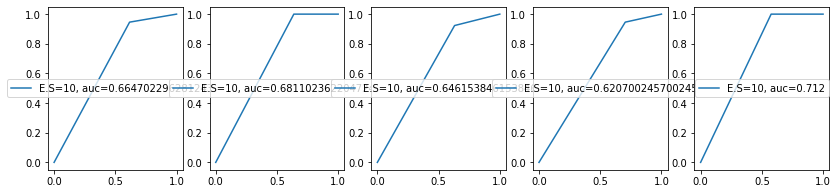

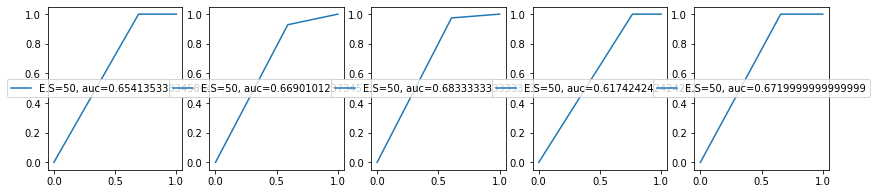

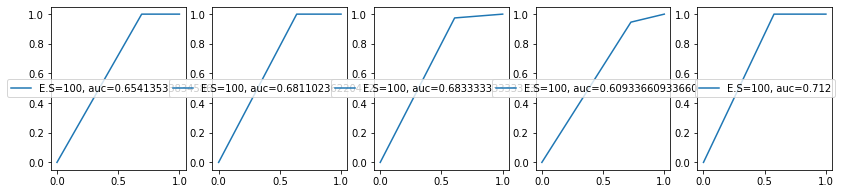

In [13]:
def train_smoteboost(xtrain, ytrain, xtest, ytest, indx, ensemble_size=10, plot_roc=False):
    
    smote = SMOTEBoost(features,labels,ensemble_size)
    smote.fit()
    
    preds=[]
    for i in range(xtest.shape[0]):
        preds.append(smote.predict(xtest[i]))
    if plot_roc:
        # plot ROC Curves
        fpr, tpr, _ = roc_curve(ytest, preds)
        roc_auc = auc(fpr, tpr)

        ax[indx].plot(fpr,tpr,label="E.S="+str(esize)+", auc="+str(roc_auc))
        ax[indx].legend(loc=10)
        if indx==5:
            plt.show()
    
    prec,recall,_,_ = precision_recall_fscore_support(preds, ytest)
    return prec,recall

ensemble_size=[10,50,100]
avg_prec_sb,avg_rcall_sb=[],[]

for esize in ensemble_size:
    # lists for storing precisions and recalls
    p_smote,r_smote=[],[]
    indx=0
    fig, ax = plt.subplots(1,5,figsize=(14,3))
    
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # SMOTEBOOST
        precision,recall = train_smoteboost(X_train, y_train,X_test,y_test,indx, esize)
        p_smote.append(precision)
        r_smote.append(recall)
        indx+=1

    print("Precision and recall for ensemble size of : "+str(esize))
    avg_prec_sb.append(np.mean(p_smote))
    avg_rcall_sb.append(np.mean(r_smote))
    print("SMOTEBOOST: Avg Precision= "+str(round(avg_prec_sb[-1],2))+" Avg Recall= "+str(round(avg_rcall_sb[-1],2)))
    print("=========================================================")

# 4. RB-Boost

In [14]:
class RBboost():
    
    def __init__(self,instances,labels, n_clf, neighbours=5):
        self.X = instances
        self.y = labels.tolist()
        
        self.clf = []
        self.n_clf = n_clf
            
        self.weights = []
        self.init_weight= 1.0 / len(self.X)
        for i in range(len(self.X)):# assign initial weights
            self.weights.append(self.init_weight)

        self.beta = []
        
        self.majority_size = self.y.count(0)
        self.minority_size = self.y.count(1)
        self.k = neighbours
        
    def sample(self, n_samples, minority):

        S = np.zeros(shape=(n_samples, self.n_features))
        # Calculate synthetic samples.
        j=0
        for i in range(n_samples):
            if minority: # choose from minority class data
                j = np.random.choice(self.minority_size)
                j+= self.majority_size
            else: # choose from majority class data
                j = np.random.choice(self.majority_size)

            # Find the NN for each sample.
            # Exclude the sample itself.
            nn = self.neigh.kneighbors(self.X[j].reshape(1, -1),
                                       return_distance=False)[:, 1:]
            
            nn_index = np.random.choice(nn[0]) # select one of the nearest neighbours randomly

            dif = self.X[nn_index] - self.X[j]
            gap = np.random.random()

            S[i, :] = self.X[j, :] + gap * dif[:] # create artificial data

        return S

    def fit_knn(self,xin):

        self.n_samples, self.n_features = xin.shape
        # Learn nearest neighbors.
        self.neigh = NearestNeighbors(n_neighbors=self.k + 1)
        self.neigh.fit(xin)

    def random_balance(self):
        
        total_size = len(self.y)
        # randomly pick a majority class size > 2
        new_majority_size = np.random.randint(2, total_size - 2)
        new_minority_size = total_size - new_majority_size
        
        X_min = self.X[np.where(np.asarray(self.y) == 1)]
        X_maj = self.X[np.where(np.asarray(self.y) == 0)]
        
        
        randbal_data=[]
        if new_majority_size < self.majority_size:# if new majority class size was lower than original
            # randomly select 'new_majority_size' number of instances from original maj class
            self.fit_knn(X_min)
            indices = np.random.choice(self.majority_size, new_majority_size)
            
            for index in indices:
                randbal_data.append([self.weights[index],self.X[index],0])
            # upsample minority class data
            upsamples = self.sample(new_minority_size - self.minority_size,minority=True)
            
            for i in range(upsamples.shape[0]):
                randbal_data.append([1./total_size, upsamples[i], 1])
        else:# if new majority class size was higher than original
            self.fit_knn(X_maj)
            # randomly select 'new_minority_size' number of instances from original minority class
            indices = np.random.choice(self.minority_size, new_minority_size)
            
            for index in indices:
                randbal_data.append([self.weights[index],self.X[index],1])
            # upsample majority class data
            upsamples = self.sample(new_majority_size - self.majority_size,minority=False)
            for i in range(upsamples.shape[0]):
                randbal_data.append([1./total_size, upsamples[i], 1])
        return randbal_data
    
    def fit(self):
        for k in range(self.n_clf):

            # check tree accuracy , remove if it was below .5
            acc = 0.0
            acc_sampled = 0.0
            base_classifier = None
            while acc < 0.5 or acc_sampled < 0.5:
                sampled = self.random_balance()

                sampled_weight = [s[0] for s in sampled]
                sampled_X      = [s[1] for s in sampled]
                sampled_Y       = [s[2] for s in sampled]
                   
                # try again fitting new tree
                base_classifier = DT(max_depth=2)
                base_classifier.fit(sampled_X, sampled_Y, sampled_weight)
            
                acc = accuracy_score(self.y, base_classifier.predict(self.X))
                acc_sampled = accuracy_score(sampled_Y, base_classifier.predict(sampled_X))
            
            self.clf.append(base_classifier)
            loss = 0
            for x,y,w in zip(self.X, self.y, self.weights):
                x = x.reshape(1,-1)
                probs = self.clf[k].predict_proba(x)[0]
                pred = self.clf[k].predict(x)[0]
                if y != pred:
                    loss+= w * (1 - probs[y] + probs[pred])
            loss *= 0.5
            beta = loss/(1-loss)
            if math.isnan(beta) or beta == 0:
                beta = 1
            self.beta.append(beta)
            if loss > 0: # update weights if there is a loss
                
                for i in range(len(self.weights)):
                    x = self.X[i]
                    x = x.reshape(1,-1)
                    probs = self.clf[k].predict_proba(x)[0]
                    pred = self.clf[k].predict(x)[0]
                    #if self.y[i] != pred:
                    self.weights[i] = self.weights[i] * (np.power(beta,(0.5*(1 + probs[y] - probs[pred]))))
            
            # use total sum to normalize sum of weights to 1.0
            sum_weight = sum(self.weights)
            self.weights = [w / sum_weight for w in self.weights]
            
    def predict(self, instance):
        p_score, n_score = 0 , 0
        instance = instance.reshape(1,-1)
        for i in range(self.n_clf):
            pred = self.clf[i].predict(instance)[0]
            probs = self.clf[i].predict_proba(instance)[0]
            if pred == 1:
                p_score += np.log(1./self.beta[i])* probs[1]
            else:
                n_score += np.log(1./self.beta[i])* probs[0]
        if n_score <= p_score:
            return 1
        else:
            return 0

Precision and recall for ensemble size of : 10
RBBOOST: Avg Precision= 0.51 Avg Recall= 0.41
Precision and recall for ensemble size of : 50
RBBOOST: Avg Precision= 0.62 Avg Recall= 0.59
Precision and recall for ensemble size of : 100
RBBOOST: Avg Precision= 0.66 Avg Recall= 0.63


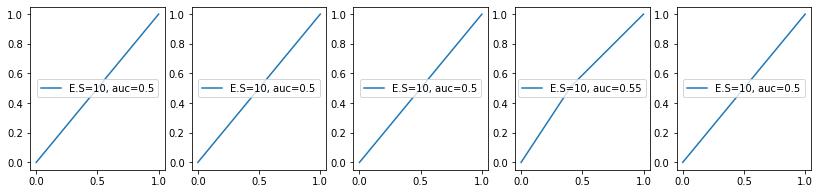

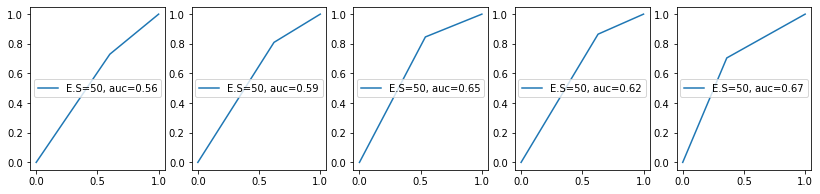

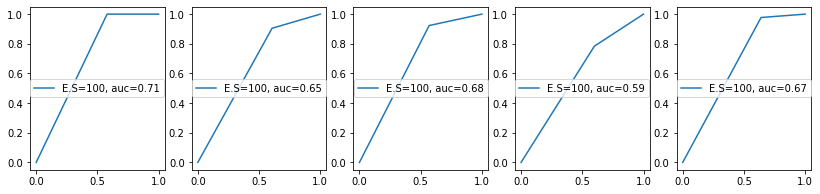

In [15]:
def train_rbboost(xtrain, ytrain, xtest, ytest, indx,ensemble_size=10, plot_roc=False):
    
    rbboost = RBboost(features,labels,ensemble_size)
    rbboost.fit()
    
    preds=[]
    for i in range(xtest.shape[0]):
        preds.append(rbboost.predict(xtest[i]))
    if plot_roc:
        # plot ROC curves   
        fpr, tpr, _ = roc_curve(ytest, preds)
        roc_auc = auc(fpr, tpr)

        ax[indx].plot(fpr,tpr,label="E.S="+str(esize)+", auc="+str(round(roc_auc,2)))
        ax[indx].legend(loc=10)
        if indx==5:
            plt.show()
    
    prec,recall,_,_ = precision_recall_fscore_support(preds, ytest)
    return prec,recall


ensemble_size=[10,50,100]
avg_prec_rbb,avg_rcall_rbb=[],[]

for esize in ensemble_size:
    # lists for storing precisions and recalls
    p_rbb,r_rbb=[],[]
    indx=0
    fig, ax = plt.subplots(1,5,figsize=(14,3))
    
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # RBBOOST
        precision,recall = train_rbboost(X_train, y_train,X_test,y_test, indx, esize)
        p_rbb.append(precision)
        r_rbb.append(recall)
        indx+=1
        
    print("Precision and recall for ensemble size of : "+str(esize))
    avg_prec_rbb.append(np.mean(p_rbb))
    avg_rcall_rbb.append(np.mean(r_rbb))
    print("RBBOOST: Avg Precision= "+str(round(avg_prec_rbb[-1],2))+" Avg Recall= "+str(round(avg_rcall_rbb[-1],2)))
    print("=========================================================")

# 5. SVM and Random Forest

Precision and recall for ensemble size of : 10
RANDOM Forest: Avg Precision= 0.92 Avg Recall= 0.94
Precision and recall for ensemble size of : 50
RANDOM Forest: Avg Precision= 0.96 Avg Recall= 0.96
Precision and recall for ensemble size of : 100
RANDOM Forest: Avg Precision= 0.96 Avg Recall= 0.96
SVM: Precision= 1.0 Recall= 0.97



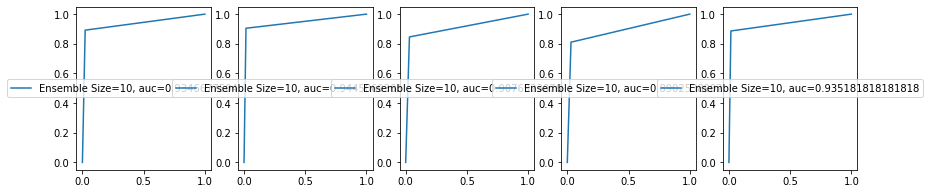

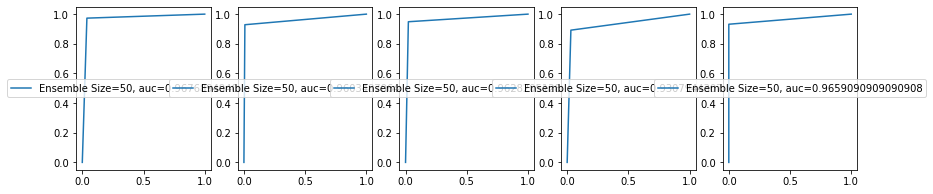

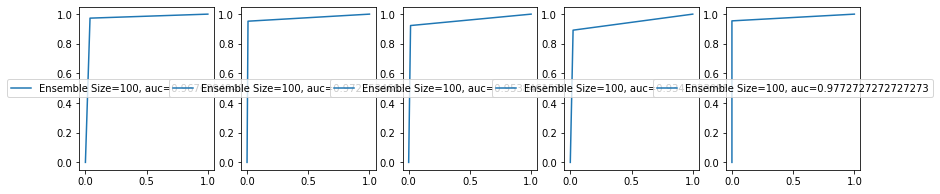

In [21]:
def train_svm(xtrain, ytrain, xtest, ytest):
    clf = LinearSVC(random_state=0)
    clf.fit(xtrain,ytrain)
    
    preds=[]
    for i in range(xtest.shape[0]):
        preds.append(clf.predict(xtest[i].reshape(1,-1)))
    prec,recall,_,_ = precision_recall_fscore_support(preds, ytest)
    
    return prec,recall

def train_randomforest(xtrain, ytrain, xtest, ytest, indx,ensemble_size=10 , plot_roc=False):
    clf = RandomForestClassifier(n_estimators=ensemble_size,random_state=0)
    clf.fit(xtrain,ytrain)
    
    preds=[]
    for i in range(xtest.shape[0]):
        preds.append(clf.predict(xtest[i].reshape(1,-1)))
    
    if plot_roc:
        fpr, tpr, _ = roc_curve(ytest, preds)
        roc_auc = auc(fpr, tpr)

        ax[indx].plot(fpr,tpr,label="Ensemble Size="+str(esize)+", auc="+str(roc_auc))
        ax[indx].legend(loc=10)
        if indx==5:
            plt.show()
    
    prec,recall,_,_ = precision_recall_fscore_support(preds, ytest)
    
    return prec,recall


ensemble_size=[10,50,100]# RandomForest
avg_prec_rf, avg_rcall_rf=[], []
for esize in ensemble_size:
    # lists for storing precisions and recalls
    p_rf,r_rf=[],[]
    indx=0
    fig, ax = plt.subplots(1,5,figsize=(14,3))
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # RANDOM Forest
        precision,recall= train_randomforest(X_train, y_train,X_test,y_test, indx, esize, True)
        p_rf.append(precision)
        r_rf.append(recall)
        indx+=1
    print("Precision and recall for ensemble size of : "+str(esize))
    avg_prec_rf.append(np.mean(p_rf))
    avg_rcall_rf.append(np.mean(r_rf))
    print("RANDOM Forest: Avg Precision= "+str(round(avg_prec_rf[-1],2))+" Avg Recall= "+str(round(avg_rcall_rf[-1],2)))
    print("=========================================================")

# SVM
precision,recall = train_svm(X_train, y_train,X_test,y_test)
p_svm = precision
r_svm = recall

print("SVM: Precision= "+str(round(p_svm[0],2))+" Recall= "+str(round(r_svm[0],2)))
print()

# 6. Results

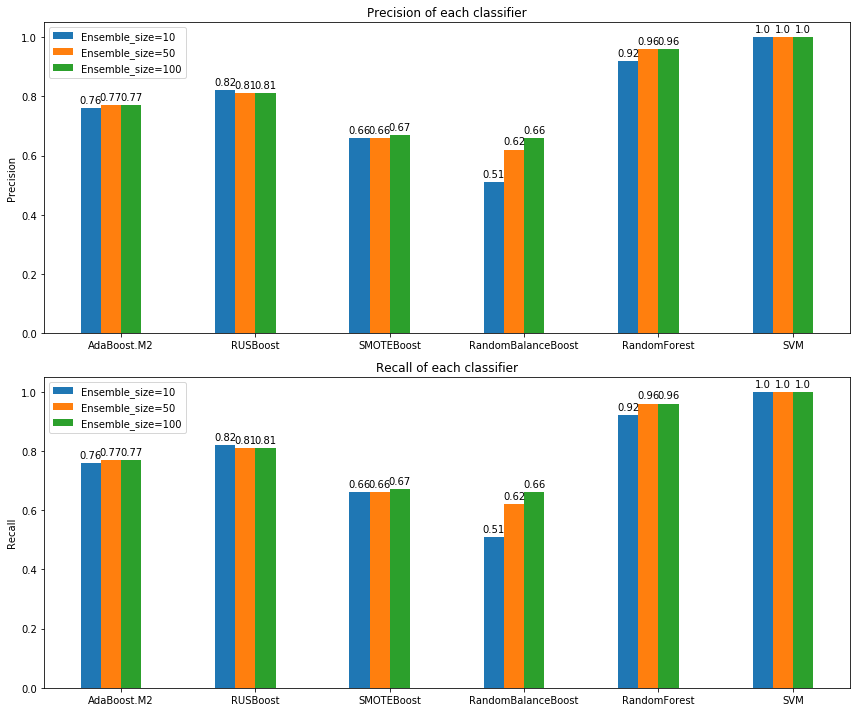

Average Classifier Precision for AdaBoost :          0.77
Average Classifier Precision for RUSBoost :          0.82
Average Classifier Precision for SMOTEBoost :        0.66
Average Classifier Precision for RandomBalanceBoost :0.6
Average Classifier Precision for RandomForest :      0.95
Average Classifier Precision for SVM :               1.0
--------------------------------------------------------------
*Best performing method based on Average Precision of classifiers: "SVM"

*Best Performing Ensemble Classifier is "Random Forset" Runner up (second best) is RUSBOOST

--------------------------------------------------------------------------------

Taha Samavati - 98722134 - Analysis of final results


In [23]:
# Plot and analyse results
def autolabel(rects,i):
    """Attach a text label above each bar """
    for rect in rects:
        height = rect.get_height()
        ax[i].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

y_preds = [avg_prec_ada[0], avg_prec_rb[0], avg_prec_sb[0], avg_prec_rbb[0], avg_prec_rf[0],p_svm[0]]
y_preds1 = [avg_prec_ada[1], avg_prec_rb[1], avg_prec_sb[1], avg_prec_rbb[1], avg_prec_rf[1],p_svm[0]]
y_preds2 = [avg_prec_ada[2], avg_prec_rb[2], avg_prec_sb[2], avg_prec_rbb[2], avg_prec_rf[2],p_svm[0]]

y_preds3 = [avg_rcall_ada[0], avg_rcall_rb[0], avg_rcall_sb[0], avg_rcall_rbb[0], avg_rcall_rf[0],r_svm[0]]
y_preds4 = [avg_rcall_ada[1], avg_rcall_rb[1], avg_rcall_sb[1], avg_rcall_rbb[1], avg_rcall_rf[1],r_svm[0]]
y_preds5 = [avg_rcall_ada[2], avg_rcall_rb[2], avg_rcall_sb[2], avg_rcall_rbb[2], avg_rcall_rf[2],r_svm[0]]

method_names=['AdaBoost.M2','RUSBoost','SMOTEBoost','RandomBalanceBoost','RandomForest','SVM']
ensemble_size=['Ensemble=10','Ensemble=50','Ensemble=100']
fig, ax = plt.subplots(2,figsize=(12,10))
labels = method_names

data = np.round(y_preds,2)
data_1 = np.round(y_preds1,2)
data_2 = np.round(y_preds2,2)
data_3 = np.round(y_preds3,2)
data_4 = np.round(y_preds4,2)
data_5 = np.round(y_preds5,2)

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars


rects1 = ax[0].bar(x - (width+0.3)/2, data, width, label="Ensemble_size=10")
rects2 = ax[0].bar(x - (width+0.15)/4, data_1, width, label="Ensemble_size=50")
rects3 = ax[0].bar(x + (width+0.15)/4, data_2, width, label="Ensemble_size=100")

rects4 = ax[1].bar(x - (width+0.3)/2, data, width, label="Ensemble_size=10")
rects5 = ax[1].bar(x - (width+0.15)/4, data_1, width, label="Ensemble_size=50")
rects6 = ax[1].bar(x + (width+0.15)/4, data_2, width, label="Ensemble_size=100")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision of each classifier')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

ax[1].set_ylabel('Recall')
ax[1].set_title('Recall of each classifier')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

autolabel(rects1,0)
autolabel(rects2,0)
autolabel(rects3,0)
autolabel(rects4,1)
autolabel(rects5,1)
autolabel(rects6,1)

fig.tight_layout()

plt.show()

print("Average Classifier Precision for AdaBoost :          " + str(round(np.mean(avg_prec_ada),2)))
print("Average Classifier Precision for RUSBoost :          " + str(round(np.mean(avg_prec_rb),2)))
print("Average Classifier Precision for SMOTEBoost :        " + str(round(np.mean(avg_prec_sb),2)))
print("Average Classifier Precision for RandomBalanceBoost :" + str(round(np.mean(avg_prec_rbb),2)))
print("Average Classifier Precision for RandomForest :      " + str(round(np.mean(avg_prec_rf),2)))
print("Average Classifier Precision for SVM :               " + str(round(p_svm[0],2)))
print("--------------------------------------------------------------")
print("*Best performing method based on Average Precision of classifiers: \"SVM\"" )
print()
print("*Best Performing Ensemble Classifier is \"Random Forset\" Runner up (second best) is RUSBOOST" )
print()
print("--------------------------------------------------------------------------------")
print()
print("Taha Samavati - 98722134 - Analysis of final results")

# 7.Bonus === ANOVA Test ===

* Perform 10 random 30-70 splits and evaluate classifiers on them
* store results

In [37]:
esize = 50
p_rf,p_svm,p_rbb,p_rb,p_sb,p_ada=[],[],[],[],[],[]
for i in range(10):
    print("Iteration # "+str(i+1)+" ...")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42+i)
    prec,_ = train_randomforest(X_train, y_train,X_test,y_test,0 , esize, False)
    p_rf.append(prec)
    prec,_ = train_rbboost(X_train, y_train,X_test,y_test,0, esize, False)
    p_rbb.append(prec)
    prec,_ = train_rusboost(X_train, y_train,X_test,y_test,0, esize, False)
    p_rb.append(prec)
    prec,_ = train_smoteboost(X_train, y_train,X_test,y_test,0, esize, False)
    p_sb.append(prec)
    prec,_ = train_adaboost(X_train, y_train,X_test,y_test,0, esize, False)
    p_ada.append(prec)
    prec,_ = train_svm(X_train, y_train,X_test,y_test)
    p_svm.append(prec)

Iteration # 1 ...
Iteration # 2 ...
Iteration # 3 ...
Iteration # 4 ...
Iteration # 5 ...
Iteration # 6 ...
Iteration # 7 ...
Iteration # 8 ...
Iteration # 9 ...
Iteration # 10 ...


## ANOVA Test
* Create data frame of classifiers each with their accuracy score

In [38]:
all_scores = p_rf + p_rbb + p_rb + p_sb + p_ada + p_svm
clf_names = (['RandomForest'] * len(p_rf)) +  (['RandomBalanceBoost'] * len(p_rbb)) +  (['RUSBoost'] * len(p_rb)) +  (['SMOTEBoost'] * len(p_sb)) +  (['AdaBoostM2'] * len(p_ada)) +  (['SVM'] * len(p_svm))

In [39]:
data = pd.DataFrame({'classifier': clf_names, 'score': all_scores})

In [40]:
for i in range(len(data['score'])):
    data['score'].loc[i] = data['score'].loc[i][0]

In [44]:
# add new column group mean to data frame
ss_residual=0
data['group_mean']=0
for i in range(data.shape[0]):
    if data['classifier'].loc[i] == 'RandomForest':
        data['group_mean'].loc[i] = np.mean(p_rf)
    if data['classifier'].loc[i] == 'RandomBalanceBoost':
        data['group_mean'].loc[i] = np.mean(p_rbb)
    if data['classifier'].loc[i] == 'RUSBoost':
        data['group_mean'].loc[i] = np.mean(p_rb)
    if data['classifier'].loc[i] == 'SMOTEBoost':
        data['group_mean'].loc[i] = np.mean(p_sb)
    if data['classifier'].loc[i] == 'AdaBoostM2':
        data['group_mean'].loc[i] = np.mean(p_ada)
    if data['classifier'].loc[i] == 'SVM':
        data['group_mean'].loc[i] = np.mean(p_svm)

In [42]:
# compute overall mean
overall_mean = data['score'].mean()
overall_mean

0.7712471060405698

In [43]:
# compute Total Sum of Squares 
data['overall_mean'] = overall_mean
ss_total = sum((data['score'] - data['overall_mean'])**2)
ss_total

3.7650257087004517

In [45]:
# compute Sum of Squares (Variance) within groups
ss_residual = sum((data['score'] - data['group_mean'])**2)
ss_residual

1.7540917621642278

In [46]:
# compute Sum of Squares between groups
ss_explained = sum((data['group_mean'] - data['overall_mean'])**2)
ss_explained

0.7970251992263431

In [52]:
# num all observations and number of groups (distinct classifiers)
n_groups = len(set(data['classifier']))
n_obs = data.shape[0]
# degrees of freedom for residual
df_residual = n_obs - n_groups
print("df_residual : "+str(df_residual))
# variance within groups / (num_all_obs - num classifiers)
ms_residual = ss_residual / df_residual
print("mean square residual (within groups)")
print(ms_residual)

df_residual : 54
mean square residual (within groups)
0.032483180780819035


In [55]:
df_explained = n_groups - 1
print("df_explained : "+str(df_explained))
# compute variance between groups / (n_groups - 1)
ms_explained = ss_explained / df_explained
print("mean square explained (between groups)")
print(ms_explained)

df_explained : 5
mean square explained (between groups)
0.1594050398452686


In [54]:
# compute F-Value
f = ms_explained / ms_residual
f

4.907310060577428

In [50]:
# compute p-value
import scipy.stats
p_value = 1 - scipy.stats.f.cdf(f, df_explained, df_residual)
p_value

0.0008968784502048077

* p is less than 0.05
* Look up the F-distibution table (p<0.05), (df_residual,df_explained)=(54,5)
* **F(54,5) = 1.93 < 4.90**
* So we can reject the null hypothesis
* which means that **there is a meaningfull difference between classifiers performance.**
* This was result of 1-way ANOVA Test
* according to the result, The best classifier is one with lowes variance within groups and maximum average prec.
* the best is SVM - Second best is Random Forest

In [51]:
data

,classifier,score,overall_mean,group_mean
0,RandomForest,1,0.771247,0.941119
1,RandomForest,0.964824,0.771247,0.941119
2,RandomForest,0.968586,0.771247,0.941119
3,RandomForest,0.979167,0.771247,0.941119
4,RandomForest,0.989899,0.771247,0.941119
5,RandomForest,0.978142,0.771247,0.941119
6,RandomForest,0.984536,0.771247,0.941119
7,RandomForest,0.979487,0.771247,0.941119
8,RandomForest,0.972678,0.771247,0.941119
9,RandomForest,0.975248,0.771247,0.941119


## Taha Samavati - 98722134
### Pattern Recognition - Second Project